# Exploring Aliasing

### Setting up an aliased wave

In [13]:
import numpy as np
import cmath
import matplotlib.pyplot as plt

In [14]:
class waveGen:
	
	def __init__(self, freq, BufferSize, waveType, vol):
		
		self.sampleRate = 48000
		self.bufferSize = BufferSize
		self.buffer = np.empty(BufferSize, dtype=np.complex)
		self.frequency = freq
		self.omega = 0
		self.updateOmega()
		self.last = complex(1,0)
		self.type = waveType
		self.volume = vol

	def sineGen(self):

		#start = timer() #reduce function!!! functools
		for i in range(0, self.bufferSize):
			self.buffer[i] = self.last
			self.last=self.last*self.omega

		return self.volume * np.imag(self.buffer).astype(np.float32)

	def squareGen(self):
		#start = timer()
		for i in range(0, self.bufferSize):
			self.buffer[i] = np.sign(self.last)
			self.last=self.last*self.omega

		return np.real(self.volume * self.buffer).astype(np.float32)

	def updateOmega(self):
		self.omega = cmath.exp(1j*(2*cmath.pi * self.frequency / self.sampleRate))

	def updateFreq(self, val):
		self.frequency = val
		self.updateOmega()
        
	def updateFPS(self, val):
		self.sampleRate = val
		self.updateOmega()
        
	def updateBuffSize(self, val):
		self.bufferSize = val
		self.buffer = np.empty(self.bufferSize)
		self.updateOmega()

	def nextFrame(self):
		if self.type == "sine":
			return self.sineGen()
		elif self.type == "square":
			return self.squareGen()
		elif self.type == "triangle":
			return self.triangleGen()

In [15]:
sampleRate = 48000
length = 48000
freq = 880 
wave = waveGen(freq, length, 'square', 1)

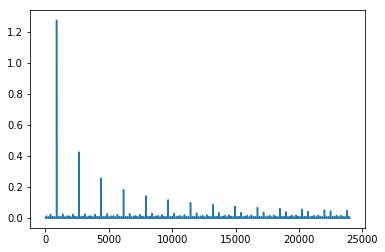

In [16]:
square = wave.nextFrame()
freqSpec = np.fft.fft(square)
#linespaceing
T = 1.0 / sampleRate

#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), length//2)

#ploting the graph
plt.plot(xf, 2.0/length * np.abs(freqSpec[:length//2]))
plt.show()

### in a pure square wave we would expect to see peaks on every other harmonic
whareas we can see here that the harmonics have looped back on themselfs, creating a background noise of around .05 decebals across the spectrum.


This distortion is allready baked into the wave, so we can try the same again by increasing the FPS, therby increasing the nyquist window

# The Over Sample wave

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


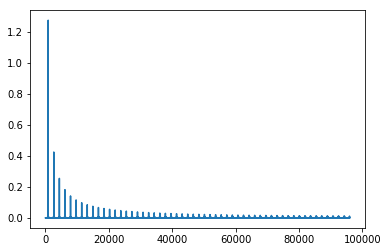

In [17]:
#an 4 times over sampled wave
overSampling = 4
wave.updateFPS(sampleRate*overSampling)
wave.updateBuffSize(length*overSampling)

#generate data
square2 = wave.nextFrame()
freqSpec2 = np.fft.fft(square2)

#linespaceing
T = 1.0 / (sampleRate*overSampling)

#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), length * overSampling//2)

#ploting the graph
plt.plot(xf, 2.0/(length*overSampling) * np.abs(freqSpec2[:length * overSampling//2]))
plt.show()

### it can be seen here that the distortion is much less apparent.
the nyquist value here should be at 96,000 HZ 

It is notable that the distortion here is higher in the higher range

the full data of the fft looks like this, and may provide a better idea of how to downSample

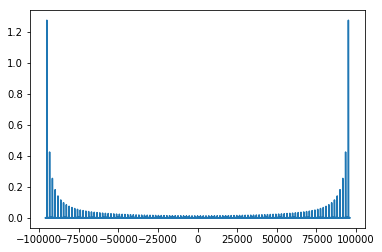

In [18]:
#linespaceing
T = 1.0 / (sampleRate*overSampling)

#x angle of plot
xf = np.linspace(-length*2, 1.0/(2.0*T), length*overSampling)

#ploting the graph
plt.plot(xf, 2.0/(length*overSampling) * np.abs(freqSpec2))
plt.show()

#### to filter here at 24000 HZ we want to nullify all values bettween -24000 and 24000


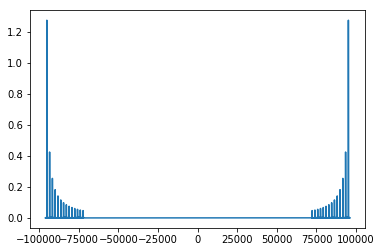

In [19]:
cutoff = sampleRate // 2

freqSpec3 = freqSpec2
for i in range(cutoff, sampleRate * overSampling - cutoff):
        freqSpec3[i] = 0
        
#ploting the graph
plt.plot(xf, 2.0/(length* overSampling) * np.abs(freqSpec3))
plt.show() 

#### we can return this to the time domain and then downSample

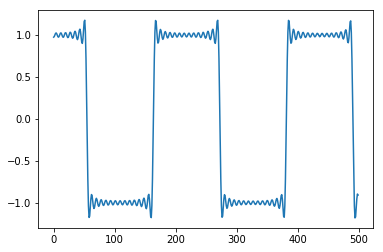

In [20]:
fltSqr = np.fft.ifft(np.real(freqSpec3))
plt.plot(np.real(fltSqr[:500]))
plt.show()

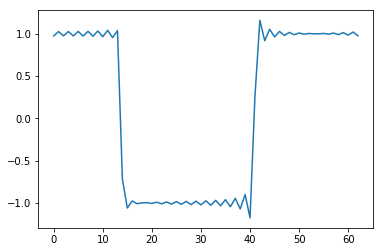

In [21]:
downSampled = np.empty(sampleRate)

for i in range(len(fltSqr)):
    if i % overSampling == 0:
        downSampled[i//overSampling] = np.real(fltSqr[i])
        
plt.plot(downSampled[:63])
plt.show()

### lets veiw this in the frequecy domain, and compare with our original graph

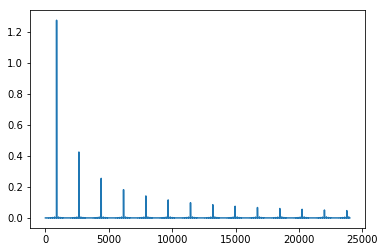

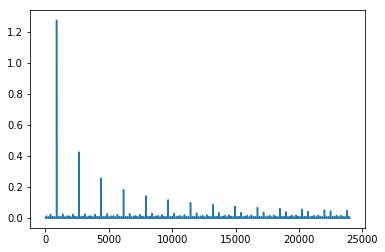

In [22]:
DSFreqSpec = np.fft.fft(downSampled)
#linespaceing
T = 1.0 / (sampleRate)
#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), sampleRate // 2)
#ploting the down sampled graph
plt.plot(xf, 2.0/length * np.abs(DSFreqSpec[:length // 2]))
plt.show()


#linespaceing
T = 1.0 / length
#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), length//2)
#ploting the original graph
plt.plot(xf, 2.0/length * np.abs(freqSpec[:length//2]))
plt.show()

### there is clearly still some Distortion, but there is at least much less
### heres a zoom on a distored area to show more clearly

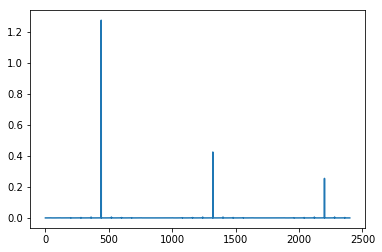

In [23]:
zoom = 10
#linespaceing
T = 1.0 / length * zoom
#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), length//zoom)
#ploting the original graph
plt.plot(xf, 2.0/length * np.abs(DSFreqSpec[:length//zoom]))
plt.show()

#### and a little closer... focusing on the distortion, with the original signal distortion plotted below

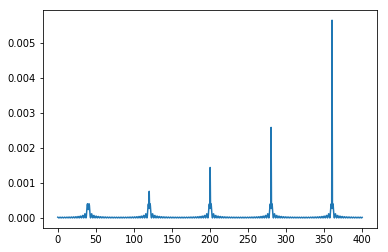

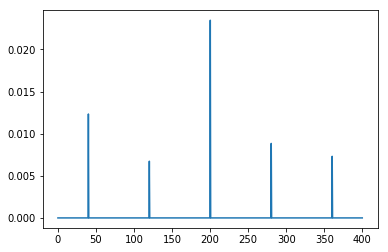

In [24]:
zoom = 60
#linespaceing
T = 1.0 / length * zoom
#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), length//zoom)
#ploting the original graph
plt.plot(xf, 2.0/length * np.abs(DSFreqSpec[:length//zoom]))
plt.show()
plt.plot(xf, 2.0/length * np.abs(freqSpec[:length//zoom]))
plt.show()

#### it can be seen here that by using this method a background distortion is prevelent across the spectrum of ~0.005 decibal at a 4 times overSample rate
thereby reducing the distortion levels by aproximatly 4 times

# This method is however computatioaly complex and far from perfect
## a priority should be in avoiding the FFT in filter design, and finding methods that can avoid high levels of over sampling